In [132]:
from pathlib import Path
import numpy as np
from crawfish.utils.testing import EXAMPLE_CALC_DIRS_DIR
from crawfish.core.operations.vector import get_gauss_smear_spectrum, get_lti_spectrum,get_uneven_integrated_array
from crawfish.core.elecdata import ElecData, los_projs_for_bands
from crawfish.funcs.general import SIGMA_DEFAULT, RES_DEFAULT
from crawfish.utils.typing import REAL_DTYPE, cs_formatter, COMPLEX_DTYPE
import matplotlib.pyplot as plt

def get_best_bands(unnorm_proj_tju):
    nstates = np.shape(unnorm_proj_tju)[0]
    nbands = np.shape(unnorm_proj_tju)[1]
    nproj = np.shape(unnorm_proj_tju)[2]
    band_proj_sums = np.zeros(nbands)
    for j in range(nbands):
        band_proj_sums[j] = np.sum(np.abs(unnorm_proj_tju[:,j,:]), axis=(0,1))
    idcs = np.argsort(band_proj_sums)[::-1]
    idcs_select = idcs[:nproj]
    idcs_sort = np.argsort(idcs_select)
    idcs_return = [idcs_select[i] for i in idcs_sort]
    return idcs_return

from numba import jit

def normalize_proj_tju(proj_tju: np.ndarray[COMPLEX_DTYPE], nloops=1000, conv=0.01):
    proj_tju_norm = proj_tju.copy()
    nproj: np.int64 = np.shape(proj_tju)[1]
    nstates: np.int64 = np.shape(proj_tju)[0]
    losses = np.zeros([nstates, nloops], dtype=REAL_DTYPE)
    proj_tju_norm = proj_tju.copy()
    return _normalize_proj_tju(proj_tju_norm, nloops, conv, losses)

@jit(nopython=True)
def _normalize_proj_tju(proj_tju_norm: np.ndarray[COMPLEX_DTYPE], nloops: int, conv: REAL_DTYPE, losses:np.ndarray[REAL_DTYPE]):
    for t in range(nstates):
        for i in range(nloops):
            for j in range(nproj):
                asum: REAL_DTYPE = 0
                for u in range(nproj):
                    asum += np.real(np.conj(proj_tju_norm[t,j,u])*proj_tju_norm[t,j,u])
                proj_tju_norm[t,j,:] *= 1/(asum**0.5)
                losses[t,i] += np.abs(1-asum)
            for u in range(nproj):
                asum: REAL_DTYPE = 0
                for j in range(nproj):
                    asum += np.real(np.conj(proj_tju_norm[t,j,u])*proj_tju_norm[t,j,u])
                proj_tju_norm[t,:,u] *= 1/(asum**0.5)
                losses[t,i] += np.abs(1-asum)
            if losses[t,i] < conv:
                break
    return proj_tju_norm, losses

n2_calcdir = EXAMPLE_CALC_DIRS_DIR / "N2_bare_min"
edata = ElecData(n2_calcdir)
#edata.norm_projs_t2()
nproj = edata.nproj
nspin = edata.nspin
nbands = edata.nproj
nstates = edata.nstates
kfolding = edata.kfolding
nk = np.prod(kfolding)
bestj = get_best_bands(edata.proj_tju)
proj_sabcju = edata.proj_sabcju.copy()[:,:,:,:,bestj,:]
proj_tju = edata.proj_tju.copy()[:,bestj,:]
e_sabcj = edata.e_sabcj.copy()[:,:,:,:,bestj]
occ_sabcj = edata.occ_sabcj.copy()[:,:,:,:,bestj]
s,a,b,c,j = occ_sabcj.shape
t = s*a*b*c
occ_tj = occ_sabcj.reshape(t,j)
wk_sabc = edata.wk_sabc.copy()
wk_t = wk_sabc.flatten()
wk_jsabc = np.array([wk_sabc for _ in range(nbands)], dtype=REAL_DTYPE)
wk_sabcj = np.moveaxis(wk_jsabc, 0, -1)

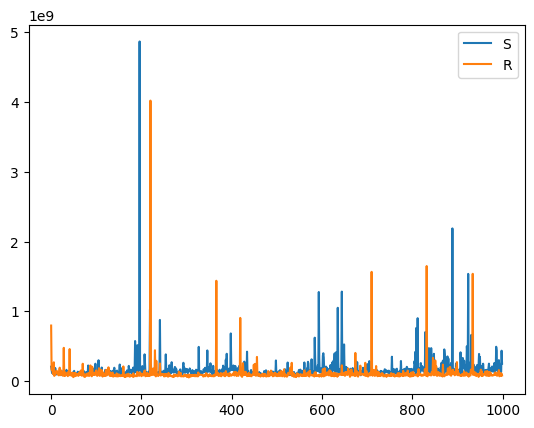

In [158]:
def normalize_proj_tju(proj_tju: np.ndarray[COMPLEX_DTYPE], nloops=1000, conv=0.01):
    proj_tju_norm = proj_tju.copy()
    nproj: np.int64 = np.shape(proj_tju)[1]
    nstates: np.int64 = np.shape(proj_tju)[0]
    losses = np.zeros([nstates, nloops, 2], dtype=REAL_DTYPE)
    proj_tju_norm = proj_tju.copy()
    return _normalize_proj_tju(proj_tju_norm, nloops, conv, losses, nstates, nproj)

#@jit(nopython=True)
def _normalize_proj_tju(
    proj_tju_norm: np.ndarray[COMPLEX_DTYPE], nloops: int, conv: REAL_DTYPE, losses:np.ndarray[REAL_DTYPE],
    nstates: int, nproj: int):
    conds = np.zeros([nloops, 2])
    for t in range(nstates):
        for i in range(nloops):
            proj_tju_norm, losses = __normalize_proj_tju(proj_tju_norm, nloops, conv, losses, nproj, t, i)
            conds[i,0] += np.abs(
                np.linalg.cond(
                    np.tensordot(np.conj(proj_tju_norm[t,:,:].T), proj_tju_norm[t,:,:], axes=([1], [0]))
                )
            )
            conds[i,1] += np.abs(
                np.linalg.cond(
                    np.tensordot(np.conj(proj_tju_norm[t,:,:].T), proj_tju_norm[t,:,:], axes=([0], [1]))
                )
            )
    return proj_tju_norm, losses, conds

@jit(nopython=True)
def __normalize_proj_tju(
    proj_tju_norm: np.ndarray[COMPLEX_DTYPE], nloops: int, conv: REAL_DTYPE, losses:np.ndarray[REAL_DTYPE], nproj: int,
    t: int, i: int):
    for j in range(nproj):
        asum: REAL_DTYPE = 0
        for u in range(nproj):
            asum += np.real(np.conj(proj_tju_norm[t,j,u])*proj_tju_norm[t,j,u])
        proj_tju_norm[t,j,:] *= 1/(asum**0.5)
        losses[t,i] += np.abs(1-asum)
    for u in range(nproj):
        asum: REAL_DTYPE = 0
        for j in range(nproj):
            asum += np.real(np.conj(proj_tju_norm[t,j,u])*proj_tju_norm[t,j,u])
        proj_tju_norm[t,:,u] *= 1/(asum**0.5)
        losses[t,i] += np.abs(1-asum)
    return proj_tju_norm, losses

nloops = 1000
nproj_tju, losses, conds = normalize_proj_tju(proj_tju, nloops=nloops, conv=0.1)
# plosses = np.sum(losses, axis=0)
# s_t_uv = np.array([np.tensordot(
#     nproj_tju[t,:,:].conj().T, nproj_tju[t,:,:], axes=([1], [0])
# ) for t in range(nstates)], dtype=COMPLEX_DTYPE)
# r_t_uv = np.array([np.tensordot(
#     nproj_tju[t,:,:].conj().T, nproj_tju[t,:,:], axes=([0], [1])
# ) for t in range(nstates)], dtype=COMPLEX_DTYPE)
# conds = np.zeros([nstates, 2])
# for t in range(nstates):
#     conds[t,0] = np.linalg.cond(s_t_uv[t])
#     conds[t,1] = np.linalg.cond(r_t_uv[t])
plt.plot(range(nloops), conds[:,0], label="S")
plt.plot(range(nloops), conds[:,1], label="R")
# plt.ylim(0,1e7)
plt.legend()

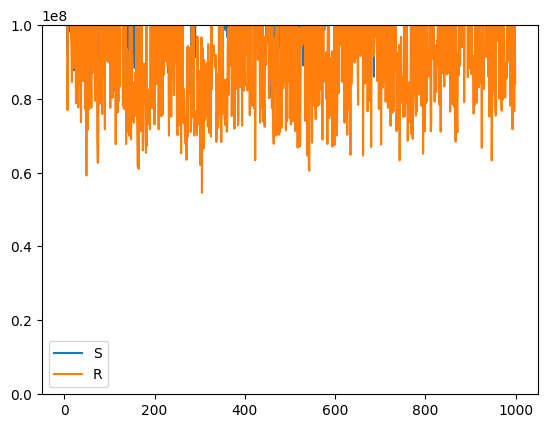

In [160]:
plt.plot(range(nloops), conds[:,0], label="S")
plt.plot(range(nloops), conds[:,1], label="R")
plt.ylim(0,1e8)
plt.legend()

In [141]:
s_t_uv = np.array([np.tensordot(
    nproj_tju[t,:,:].conj().T, nproj_tju[t,:,:], axes=([1], [0])
) for t in range(nstates)], dtype=COMPLEX_DTYPE)
r_t_uv = np.array([np.tensordot(
    nproj_tju[t,:,:].conj().T, nproj_tju[t,:,:], axes=([0], [1])
) for t in range(nstates)], dtype=COMPLEX_DTYPE)
conds = np.zeros([nstates, 2])
for t in range(nstates):
    conds[t,0] = np.linalg.cond(s_t_uv[t])
    conds[t,1] = np.linalg.cond(r_t_uv[t])
    # print(f"{np.linalg.cond(s_t_uv[t])}")
    # print(f"{np.linalg.cond(r_t_uv[t])}")
inv_s_t_uv = np.array([np.linalg.inv(s_t_uv[t]) for t in range(nstates)], dtype=COMPLEX_DTYPE)
inv_r_t_uv = np.array([np.linalg.inv(r_t_uv[t]) for t in range(nstates)], dtype=COMPLEX_DTYPE)

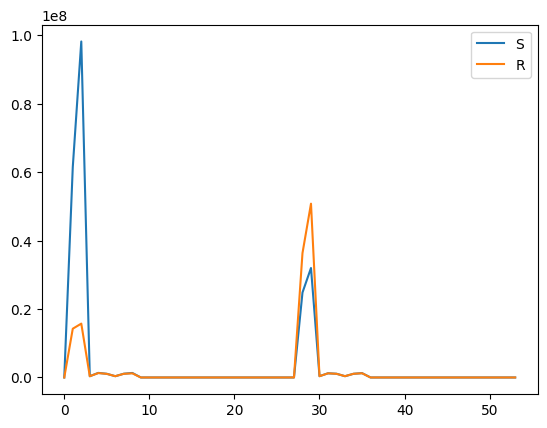

In [142]:
plt.plot(range(nstates), conds[:,0], label="S")
plt.plot(range(nstates), conds[:,1], label="R")
# plt.ylim(0,1e7)
plt.legend()

Text(0.5, 1.0, '0.42728400230407715')

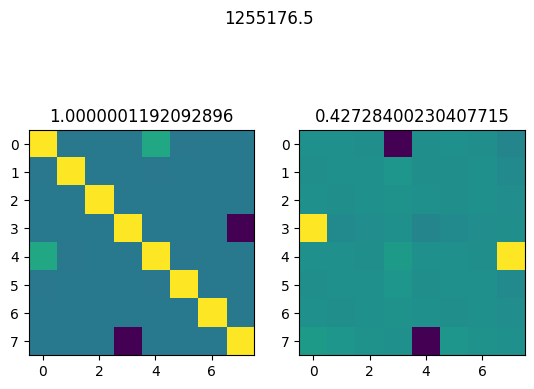

In [136]:
fig, ax = plt.subplots(ncols=2)
t= 8
fig.suptitle(f"{np.linalg.cond(s_t_uv[t])}")
ax[0].imshow(np.real(s_t_uv[t]))
ax[0].set_title(f"{np.max(np.abs(np.real(s_t_uv[t])))}")
ax[1].imshow(np.imag(s_t_uv[t]))
ax[1].set_title(f"{np.max(np.abs(np.imag(s_t_uv[t])))}")

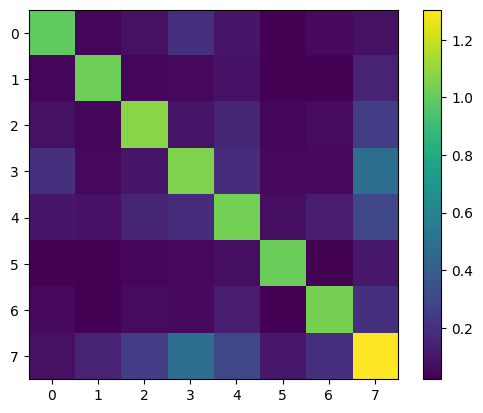

In [80]:
t = 20
matshow = np.tensordot(
    nproj_tju[t,:,:].conj().T, np.tensordot(inv_s_t_uv[t], nproj_tju[t,:,:], axes=([1], [0])), 
    axes=([1], [0])
)
plt.imshow(abs(matshow))
plt.colorbar()

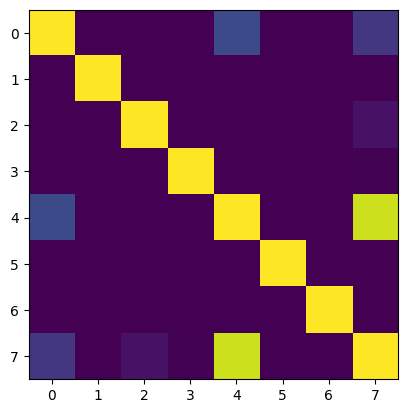

In [14]:
plt.imshow(np.abs(np.tensordot(
    nproj_tju[8].conj().T, nproj_tju[8], axes=([0],[1]))))